## Жерноклеев Дмитрий 
### Домашнее задание 2. ML часть

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

%matplotlib inline

sns.set(style="darkgrid")

### Подгрузим сгенерированную нами ранее выборку

In [2]:
df = pd.read_csv('imit_train.csv')
df

,p11,p13,p21,p23,Clients_ratio,Compet_ratio
0,0.455464,0.223689,0.257480,0.170539,0.857044,0.009142
1,0.755255,0.193673,0.142675,0.686275,0.927517,0.001305
2,0.295788,0.108266,0.817877,0.050894,0.000417,0.982334
3,0.873012,0.107089,0.739937,0.104994,0.962670,0.003308
4,0.588731,0.077179,0.668396,0.073694,0.004825,0.964741
...,...,...,...,...,...,...
2476,0.051028,0.552166,0.815959,0.082427,0.000431,0.971511
2477,0.185403,0.661061,0.386270,0.561255,0.018036,0.588520
2478,0.711005,0.247833,0.554532,0.139289,0.894758,0.009344
2479,0.270509,0.158540,0.545992,0.394945,0.011942,0.790966


In [3]:
display(df.dtypes)

p11              float64
p13              float64
p21              float64
p23              float64
Clients_ratio    float64
Compet_ratio     float64
dtype: object

### Данные импортнулись корректно

### Разобьем на обучающую и тестовую части с шафлом

In [4]:
y = df['Clients_ratio']
X = df.drop(columns=['Clients_ratio', 'Compet_ratio']).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [5]:
y_train

493     0.996627
349     0.919114
248     0.000432
1646    0.499606
1787    0.985062
          ...   
2009    0.001658
1180    0.041831
1344    0.616651
527     0.035511
1289    0.013482
Name: Clients_ratio, Length: 1984, dtype: float64

In [6]:
list(X_train.columns)

['p11', 'p13', 'p21', 'p23']

### Отскейлим данные и обучим обычную Ridge регрессию

In [7]:
numeric_features = list(X_train.columns)

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('scale', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Train RMSE = %.8f" % mean_squared_error(y_train, model.predict(X_train), squared=False))
print("Test RMSE = %.8f" % mean_squared_error(y_test, y_pred, squared=False))
print("Test R^2 = %.8f" % metrics.r2_score(y_test, y_pred))

Train RMSE = 0.23977362
Test RMSE = 0.24267526
Test R^2 = 0.71683129


### RMSE получились, на мой взгляд довольно большими, учитывая, что мы пытаемся предсказывать долю клиентов, и $R^{2}$ тоже не очень высок (0.717 не так уж близко к 1, как хотелось бы), но пусть это будет нашей бейслайн моделью 

### Попробуем выделить валидационную часть и по ней поискать более оптимальные значения коэффициента регуляризации, возможно, это поможет снизить RMSE

In [8]:
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

Best alpha = 0.00000100


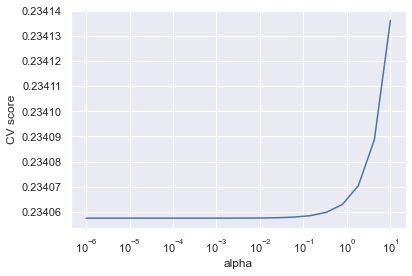

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

split_index = [-1 if x in X_train_new.index else 0 for x in X_train.index]
pds = PredefinedSplit(test_fold=split_index)

alphas = np.logspace(-6, 1, 20)
searcher = GridSearchCV(pipeline, [{"regression__alpha": alphas}], scoring="neg_root_mean_squared_error", cv=pds, n_jobs=-1)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.8f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")
plt.show()

In [12]:
pipeline = Pipeline(steps=[
    ('scale', column_transformer),
    ('regression', Ridge(best_alpha))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.8f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.24267452


### Качество не улучшилось. Попробуем проделать то же с Lasso-регрессией

Best alpha = 0.00000100


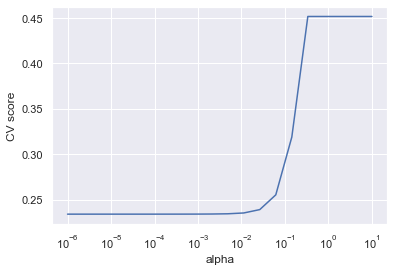

In [16]:
from sklearn.linear_model import Lasso
lasso_pipeline = Pipeline(steps=[
    ('scale', column_transformer),
    ('regression', Lasso())
])

searcher = GridSearchCV(lasso_pipeline, [{"regression__alpha": alphas}], scoring="neg_root_mean_squared_error", cv=pds, n_jobs=-1)
searcher.fit(X_train, y_train)

best_alpha1 = searcher.best_params_["regression__alpha"]
print("Best alpha = %.8f" % best_alpha1)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")
plt.show()

In [18]:
pipeline = Pipeline(steps=[
    ('scale', column_transformer),
    ('regression', Lasso(best_alpha1))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.8f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.24267442


### Качество (функционал ошибки) улучшилось на 7 знаке после запятой. Незначительное улучшение.

### Попробуем теперь обучить, например, RandomForest

In [22]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=500, max_features=int(X_train.shape[1] / 3))
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print("Test RMSE = %.8f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.12449580


### Хорошо, RMSE снизилось почти в 2 раза

### Можно ещё попробовать с помощью GridSearch поискать оптимальные гиперпараметры, и ещё улучшить нашу модель

In [32]:
param_grid = {
    'max_depth': [80, 90, 100],
    'max_features': [1, 2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 300, 500, 700]
#     'max_depth': [80, 100],
#     'max_features': [1, 2],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 300, 500, 600]
}

rfr_grid = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rfr_grid, param_grid = param_grid, scoring="neg_root_mean_squared_error",
                          cv = 3, n_jobs = -1)

In [33]:
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 300}


In [34]:
print(-grid_search.best_score_)

0.10783582397393282


In [37]:
# best_grid = grid_search.best_estimator_
# grid_accuracy = evaluate(best_grid, test_features, test_labels)

# используем подобранные GridSearch'ем параметры
rfr_best = RandomForestRegressor(n_estimators=300, max_features=3, max_depth=80, min_samples_leaf=3, min_samples_split=8)
rfr_best.fit(X_train, y_train)
y_pred = rfr_best.predict(X_test)
print("Test RMSE = %.8f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.11746500


### RMSE снизился ещё на 0.007 

### Теперь постараемся решить MultiOutput задачу, то есть пусть таргетом теперь будет вектор из двух долей (нашей фирмы и конкурента)

In [38]:
y1 = df[['Clients_ratio', 'Compet_ratio']]
X1 = df.drop(columns=['Clients_ratio', 'Compet_ratio']).copy()
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=10)

In [40]:
y_train1

,Clients_ratio,Compet_ratio
493,0.996627,0.000046
349,0.919114,0.003665
248,0.000432,0.980468
1646,0.499606,0.013120
1787,0.985062,0.000423
...,...,...
2009,0.001658,0.906209
1180,0.041831,0.742339
1344,0.616651,0.058583
527,0.035511,0.850655


### Раз на SingleOutput задаче лучшим образом показал себя случайный лес, то можно предположить, что здесь он тоже может быть уместен.

In [48]:
rfr = RandomForestRegressor(n_estimators=500, max_features=int(X_train.shape[1] / 3))
rfr.fit(X_train1, y_train1)
y_pred1 = rfr.predict(X_test1)
print("Test RMSE = %.8f" % mean_squared_error(y_test1, y_pred1, squared=False))

Test RMSE = 0.12629704


In [49]:
print("Test RMSE (non-average by outputs) = ", mean_squared_error(y_test1, y_pred1, squared=False, multioutput='raw_values'))

Test RMSE (non-average by outputs) =  [0.12518286 0.12741122]


### С Multi-Output регрессией лес справился почти так же хорошо, как и в случае с Single.